In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set_style('whitegrid')

# Harmonic Oscillator

$$q=A\cdot cos\left(\sqrt{\frac{k}{m}}t+\varphi\right), \hspace{0.5 cm} E=\frac{m}{2}\dot{q}^2+\frac{k}{2}kq^2$$
let $m=1$, $k=1$:
$$q=Acos\left(t\right), \hspace{0.5 cm} 2E=\dot{q}^2+q^2$$
$$p=m\dot q=\dot q$$
$$2E=p^2+q^2$$
which looks like an equation of a circle with radius: $r=\sqrt{2E}$.<br>
Different energies describe unique circles in phase space $(q, p)$<br>
We should parameterize initial $q$ and $p$, so that: 
$$q=\sqrt{2E}cos(t) \hspace{0.5 cm} p=\sqrt{2E}sin(t)$$
satisfies equation for $E$.

In [2]:
# time
T = np.sort(np.random.uniform(0, 20, 30))
# energies
energies = np.random.uniform(0.2, 1, 50)

In [3]:
def hamiltonian(qp):
    q = qp[0]
    p = qp[1]
    return 0.5 * p**2 + 0.5 * q**2

In [4]:
def symplectic(t, qp):
    nabla_h = grad(hamiltonian)(qp)
    dhdq = nabla_h[0]
    dhdp = nabla_h[1]
    return [dhdp, -dhdq]    

In [5]:
q = []
p = []

q_dot = []
p_dot = []

for E in energies:
    t = np.random.uniform(0, 2)
    q_init = np.sqrt(2 * E) * np.cos(t)
    p_init = np.sqrt(2 * E) * np.sin(t)
    y0 = [q_init, p_init]
    
    symplectic_ivp = solve_ivp(fun=symplectic, t_span=[0, 20], y0=y0, t_eval=T)
    q.append(symplectic_ivp['y'][0] + np.random.normal(0, 0.1, 30))
    p.append(symplectic_ivp['y'][1] + np.random.normal(0, 0.1, 30))
    
    dots = np.array([np.array(symplectic(None, qp)) for qp in symplectic_ivp['y'].T])
    q_dot.append(dots[:,0])
    p_dot.append(dots[:,1])
        
q = np.array(q)
p = np.array(p)

q_dot = np.array(q_dot)
p_dot = np.array(p_dot)

Text(0.5, 1.0, 'Generated phase space trajectory with added noise')

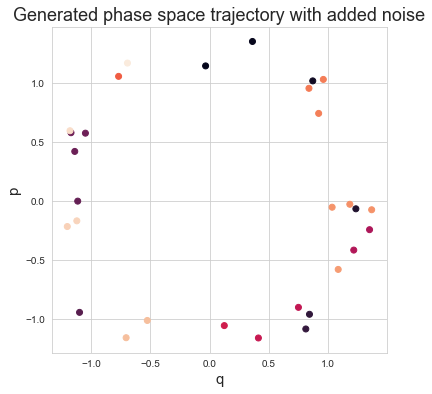

In [6]:
plt.figure(figsize=(6,6))

plt.scatter(q[0], p[0], c=T)
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.title('Generated phase space trajectory with added noise', size=18)

In [7]:
X = np.stack((q, p), axis=-1)
y = np.stack((q_dot, p_dot), axis=-1)

In [8]:
X = torch.Tensor(X)
y = torch.Tensor(y)
X.shape

torch.Size([50, 30, 2])

In [9]:
train_X, test_X = np.split(X, 2, axis=0)
train_y, test_y = np.split(y, 2, axis=0)

# Models

In [10]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(nn.Linear(2, 200),
                                  nn.Tanh(),
                                  nn.Linear(200, 200),
                                  nn.Tanh(),
                                  nn.Linear(200, 2))    
        
    def forward(self, x):
        out = self.model(x)
        
        return out

In [11]:
baseline = MLP()

In [12]:
trainset = torch.utils.data.TensorDataset(train_X, train_y)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=25,
                                          shuffle=True, num_workers=2)

In [13]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(baseline.parameters(), lr=0.001)

In [14]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = baseline(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if epoch % 5 == 0:
            print('Epoch: %d | MSE Loss: %.5f' % (epoch, running_loss))
            running_loss = 0.0
            
print('Finished Training')

Epoch: 0 | Loss: 0.57783
Epoch: 5 | Loss: 0.05334
Epoch: 10 | Loss: 0.07494
Epoch: 15 | Loss: 0.01579
Epoch: 20 | Loss: 0.03441
Epoch: 25 | Loss: 0.01556
Epoch: 30 | Loss: 0.01302
Epoch: 35 | Loss: 0.01434
Epoch: 40 | Loss: 0.00956
Epoch: 45 | Loss: 0.01128
Finished Training
